In [28]:
import pandas as pd
import numpy as np

In [29]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
import matplotlib.pyplot as plt

In [30]:
df = pd.read_csv("/content/weather_data_preprocessed.csv")

In [31]:
df.head(20)

,date,rain_or_not,pressure,avg_temperature,humidity,avg_wind_speed,cloud_cover
0,2023-01-01,1,992.965681,23.745401,46.140905,7.845981,20.851051
1,2023-01-02,1,1037.273025,30.030503,59.876587,5.382457,93.059521
2,2023-01-03,1,1034.193357,28.365224,51.464618,13.158008,11.636640
3,2023-01-04,1,968.610142,27.550929,53.103799,5.886677,81.744971
4,2023-01-05,1,1030.264331,23.639303,57.826186,12.248992,38.062329
5,2023-01-06,1,995.818689,24.148136,49.703435,6.587024,87.797432
6,2023-01-07,1,998.296887,23.671006,63.997418,5.654166,86.805669
7,2023-01-08,1,963.347997,32.245441,67.083073,6.940197,80.592540
8,2023-01-09,1,958.060151,30.078517,64.088581,4.520668,79.003044
9,2023-01-10,1,1022.793931,31.620631,71.876470,11.214141,30.467914


# Traditional Models

Evaluating LogisticRegression
Model: LogisticRegression
Cross-Validation Accuracy: 0.6238 (+/- 0.0248)
Cross-Validation ROC AUC: 0.6808 (+/- 0.0382)
Classification Report:
               precision    recall  f1-score   support

           0       0.62      0.61      0.62       198
           1       0.62      0.64      0.63       198

    accuracy                           0.62       396
   macro avg       0.62      0.62      0.62       396
weighted avg       0.62      0.62      0.62       396

--------------------------------------------------
Evaluating DecisionTree
Model: DecisionTreeClassifier
Cross-Validation Accuracy: 0.6262 (+/- 0.0234)
Cross-Validation ROC AUC: 0.6442 (+/- 0.0476)
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       198
           1       1.00      1.00      1.00       198

    accuracy                           1.00       396
   macro avg       1.00      1.00      1.00       396
weight

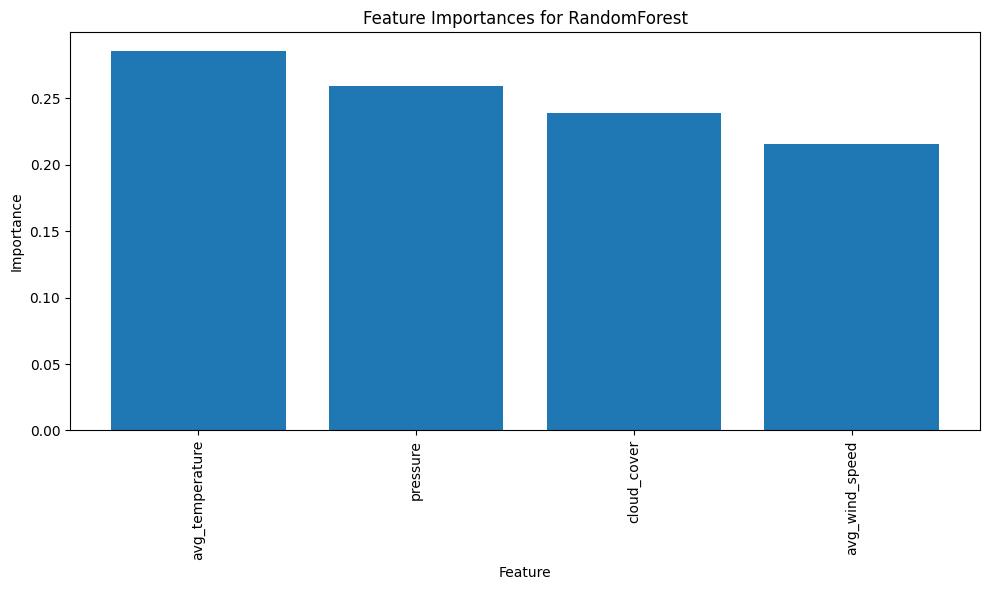

In [32]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
import matplotlib.pyplot as plt


from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import xgboost as xgb

df = df.drop(columns=['date', 'humidity'])


X = df.drop(columns=['rain_or_not'])
y = df['rain_or_not']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply SMOTE to balance the classes
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y)

# Define a function to perform cross-validation and evaluate models
def evaluate_model_with_cv(model, X, y, n_splits=5):
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    accuracy_scores = cross_val_score(model, X, y, cv=cv, scoring='accuracy')
    roc_auc_scores = cross_val_score(model, X, y, cv=cv, scoring='roc_auc')

    print(f"Model: {model.__class__.__name__}")
    print(f"Cross-Validation Accuracy: {np.mean(accuracy_scores):.4f} (+/- {np.std(accuracy_scores):.4f})")
    print(f"Cross-Validation ROC AUC: {np.mean(roc_auc_scores):.4f} (+/- {np.std(roc_auc_scores):.4f})")

    model.fit(X, y)
    y_pred = model.predict(X)
    print("Classification Report:\n", classification_report(y, y_pred))
    print("-" * 50)

    return np.mean(roc_auc_scores)

models = {
    'LogisticRegression': LogisticRegression(),
    'DecisionTree': DecisionTreeClassifier(),
    'RandomForest': RandomForestClassifier(n_estimators=100),
    'SVM': SVC(probability=True),
    'XGBoost': xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}

best_model_name = None
best_score = -1
for name, model in models.items():
    print(f"Evaluating {name}")
    score = evaluate_model_with_cv(model, X_resampled, y_resampled)
    if score > best_score:
        best_score = score
        best_model_name = name

print(f"\nBest Model: {best_model_name} with ROC AUC: {best_score:.4f}")

if best_model_name in ['RandomForest', 'XGBoost', 'DecisionTree']:
    best_model = models[best_model_name]
    best_model.fit(X_resampled, y_resampled)

    if best_model_name == 'RandomForest':
        importances = best_model.feature_importances_
    elif best_model_name == 'XGBoost':
        importances = best_model.feature_importances_
    elif best_model_name == 'DecisionTree':
        importances = best_model.feature_importances_

    feature_names = X.columns
    indices = np.argsort(importances)[::-1]

    plt.figure(figsize=(10, 6))
    plt.title(f"Feature Importances for {best_model_name}")
    plt.bar(range(X.shape[1]), importances[indices], align="center")
    plt.xticks(range(X.shape[1]), [feature_names[i] for i in indices], rotation=90)
    plt.xlabel("Feature")
    plt.ylabel("Importance")
    plt.tight_layout()
    plt.show()
else:
    print(f"Feature importance is not applicable for {best_model_name}")

Evaluating LightGBM
Model: LGBMClassifier
Cross-Validation Accuracy: 0.6894 (+/- 0.0234)
Cross-Validation ROC AUC: 0.7252 (+/- 0.0372)
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.97      0.99       198
           1       0.98      1.00      0.99       198

    accuracy                           0.99       396
   macro avg       0.99      0.99      0.99       396
weighted avg       0.99      0.99      0.99       396

--------------------------------------------------
LightGBM Cross-Validation Accuracy: 0.6894
LightGBM ROC AUC: 0.7252


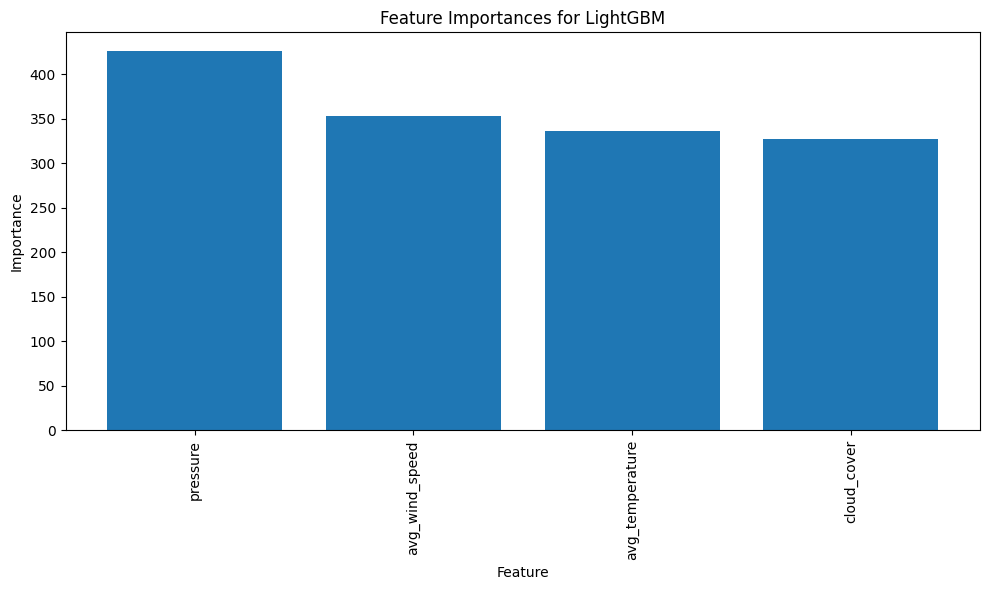

In [33]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
import matplotlib.pyplot as plt
import lightgbm as lgb
import warnings
import logging


logging.getLogger('lightgbm').setLevel(logging.ERROR)

df = pd.read_csv('/content/weather_data_preprocessed.csv')


df = df.drop(columns=['date', 'humidity'])


X = df.drop(columns=['rain_or_not'])
y = df['rain_or_not']

# Standardization
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply SMOTE to balance the classes
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y)

def evaluate_model_with_cv(model, X, y, n_splits=5):
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    accuracy_scores = cross_val_score(model, X, y, cv=cv, scoring='accuracy')
    roc_auc_scores = cross_val_score(model, X, y, cv=cv, scoring='roc_auc')

    accuracy_mean = np.mean(accuracy_scores)
    roc_auc_mean = np.mean(roc_auc_scores)

    print(f"Model: {model.__class__.__name__}")
    print(f"Cross-Validation Accuracy: {accuracy_mean:.4f} (+/- {np.std(accuracy_scores):.4f})")
    print(f"Cross-Validation ROC AUC: {roc_auc_mean:.4f} (+/- {np.std(roc_auc_scores):.4f})")


    model.fit(X, y)
    y_pred = model.predict(X)
    print("Classification Report:\n", classification_report(y, y_pred))
    print("-" * 50)

    return accuracy_mean, roc_auc_mean


print("Evaluating LightGBM")
lgbm_model = lgb.LGBMClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
accuracy_score, roc_auc_score = evaluate_model_with_cv(lgbm_model, X_resampled, y_resampled)

print(f"LightGBM Cross-Validation Accuracy: {accuracy_score:.4f}")
print(f"LightGBM ROC AUC: {roc_auc_score:.4f}")

# Plot feature importance for LightGBM
importance = lgbm_model.feature_importances_
feature_names = X.columns
indices = np.argsort(importance)[::-1]

plt.figure(figsize=(10, 6))
plt.title("Feature Importances for LightGBM")
plt.bar(range(X.shape[1]), importance[indices], align="center")
plt.xticks(range(X.shape[1]), [feature_names[i] for i in indices], rotation=90)
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()

In [34]:
def evaluate_model_with_cv(model, X, y, n_splits=5):
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    accuracy_scores = cross_val_score(model, X, y, cv=cv, scoring='accuracy')
    roc_auc_scores = cross_val_score(model, X, y, cv=cv, scoring='roc_auc')

    print(f"Model: {model.__class__.__name__}")
    print(f"Cross-Validation Accuracy: {np.mean(accuracy_scores):.4f} (+/- {np.std(accuracy_scores):.4f})")
    print(f"Cross-Validation ROC AUC: {np.mean(roc_auc_scores):.4f} (+/- {np.std(roc_auc_scores):.4f})")

    # Fit the model on the entire dataset to get the classification report
    model.fit(X, y)
    y_pred = model.predict(X)
    print("Classification Report:\n", classification_report(y, y_pred))
    print("-" * 50)

    return np.mean(roc_auc_scores)  # Return ROC AUC score for model comparison


In [35]:
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
import lightgbm as lgb
from sklearn.model_selection import cross_val_predict


df = pd.read_csv('/content/weather_data_preprocessed.csv')


df = df.drop(columns=['date', 'humidity'])

X = df.drop(columns=['rain_or_not'])
y = df['rain_or_not']


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y)

# Define base models
rf = RandomForestClassifier(n_estimators=100, random_state=42)
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
dt = DecisionTreeClassifier(random_state=42)
lgbm_model = lgb.LGBMClassifier(n_estimators=100, learning_rate=0.1, random_state=42,verbosity=-1)

# Create an ensemble model using soft voting
ensemble_model = VotingClassifier(
    estimators=[
        ('RandomForest', rf),
        #('XGBoost', xgb_model),
        #('DecisionTree', dt),
        ('LightBGM', lgbm_model)
    ],
    voting='soft'
)

# Evaluate the ensemble model
print("Evaluating Ensemble Model")
evaluate_model_with_cv(ensemble_model, X_resampled, y_resampled)


Evaluating Ensemble Model
Model: VotingClassifier
Cross-Validation Accuracy: 0.6944 (+/- 0.0271)
Cross-Validation ROC AUC: 0.7418 (+/- 0.0327)
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      1.00       198
           1       0.99      1.00      1.00       198

    accuracy                           1.00       396
   macro avg       1.00      1.00      1.00       396
weighted avg       1.00      1.00      1.00       396

--------------------------------------------------


0.741801282051282

In [36]:
import pandas as pd
import numpy as np
import warnings
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
import lightgbm as lgb
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from imblearn.combine import SMOTEENN


warnings.filterwarnings("ignore")

df = pd.read_csv('/content/weather_data_preprocessed.csv')


df = df.drop(columns=['date', 'humidity'])


X = df.drop(columns=['rain_or_not'])
y = df['rain_or_not']

# Standardization
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply SMOTE-ENN
smote_enn = SMOTEENN(random_state=42)
X_resampled, y_resampled = smote_enn.fit_resample(X_scaled, y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)

rf = RandomForestClassifier(n_estimators=100, random_state=42)
xgb_model = xgb.XGBClassifier(eval_metric='logloss', random_state=42)
dt = DecisionTreeClassifier(random_state=42)
lgbm_model = lgb.LGBMClassifier(n_estimators=100, learning_rate=0.1, random_state=42, verbosity=-1)

# Create an ensemble model using soft voting
ensemble_model = VotingClassifier(
    estimators=[
        ('RandomForest', rf),
        ('XGBoost', xgb_model),
        ('DecisionTree', dt),
        ('LightGBM', lgbm_model)
    ],
    voting='soft'
)


ensemble_model.fit(X_train, y_train)


y_pred = ensemble_model.predict(X_test)
y_prob = ensemble_model.predict_proba(X_test)[:, 1]


accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob)

# Print results
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'ROC-AUC Score: {roc_auc:.4f}')


Accuracy: 0.8846
Precision: 0.9091
Recall: 0.8333
F1 Score: 0.8696
ROC-AUC Score: 0.9167


Epoch 1/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 13s 117ms/step - accuracy: 0.6251 - loss: 0.6769 - val_accuracy: 0.6333 - val_loss: 0.6355
Epoch 2/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.5526 - loss: 0.6952 - val_accuracy: 0.6500 - val_loss: 0.6272
Epoch 3/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 0.6254 - loss: 0.6489 - val_accuracy: 0.6833 - val_loss: 0.6434
Epoch 4/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - accuracy: 0.6175 - loss: 0.6572 - val_accuracy: 0.7000 - val_loss: 0.6207
Epoch 5/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.5886 - loss: 0.6802 - val_accuracy: 0.7333 - val_loss: 0.6281
Epoch 6/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.6008 - loss: 0.6427 - val_accuracy: 0.6333 - val_loss: 0.6544
Epoch 7/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - accuracy: 0.6338 - loss: 0.6491 - val_accuracy: 0.7167 - val_loss: 0.6222
Epoch 8/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.6382 - loss: 0.6457 - val_accuracy: 

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 807ms/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 863ms/step
              precision    recall  f1-score   support

           0       0.52      0.46      0.49        26
           1       0.62      0.68      0.65        34

    accuracy                           0.58        60
   macro avg       0.57      0.57      0.57        60
weighted avg       0.58      0.58      0.58        60



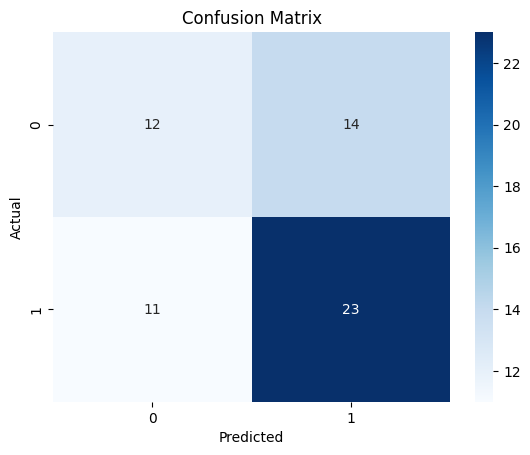

In [37]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix


df = pd.read_csv("/content/weather_data_preprocessed.csv")


df["date"] = pd.to_datetime(df["date"])
df["day_of_year"] = df["date"].dt.dayofyear
df["month"] = df["date"].dt.month
df["season"] = df["month"] % 12 // 3 + 1

X = df.drop(["date", "rain_or_not"], axis=1)
y = df["rain_or_not"]


scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

def create_sequences(data, labels, sequence_length=10):
    Xs, ys = [], []
    for i in range(len(data) - sequence_length):
        Xs.append(data[i : i + sequence_length])
        ys.append(labels[i + sequence_length])
    return np.array(Xs), np.array(ys)

sequence_length = 15
X_seq, y_seq = create_sequences(X_scaled, y.values, sequence_length)

X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42)

X_train_resampled, y_train_resampled = SMOTE(random_state=42).fit_resample(
    X_train.reshape(X_train.shape[0], -1), y_train
)
X_train_resampled = X_train_resampled.reshape(-1, sequence_length, X_train.shape[2])  # Reshape for LSTM

#Define LSTM Model
model = Sequential([
    Bidirectional(LSTM(128, return_sequences=True, input_shape=(sequence_length, X_train.shape[2]))),
    Dropout(0.3),
    Bidirectional(LSTM(64, return_sequences=True)),
    Dropout(0.3),
    LSTM(32),
    Dropout(0.3),
    Dense(1, activation="sigmoid")  # Binary Classification Output
])

model.compile(optimizer=Adam(learning_rate=0.001), loss="binary_crossentropy", metrics=["accuracy"])

history = model.fit(X_train_resampled, y_train_resampled, validation_data=(X_test, y_test),
                    epochs=100, batch_size=16, verbose=1)

y_pred = (model.predict(X_test) > 0.5).astype(int)
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 214ms/step - accuracy: 0.4119 - loss: 0.7031 - val_accuracy: 0.7917 - val_loss: 0.6759 - learning_rate: 0.0010
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.6346 - loss: 0.6744 - val_accuracy: 0.6667 - val_loss: 0.6398 - learning_rate: 0.0010
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.6507 - loss: 0.6664 - val_accuracy: 0.7083 - val_loss: 0.6253 - learning_rate: 0.0010
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.6276 - loss: 0.6424 - val_accuracy: 0.7083 - val_loss: 0.6014 - learning_rate: 0.0010
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.6244 - loss: 0.6489 - val_accuracy: 0.7917 - val_loss: 0.5775 - learning_rate: 0.0010
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.6155 - loss: 0.6566 - val_accuracy: 0.7083 - val_loss: 0.6002 - learning_rate: 0.0010
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.6600 - loss: 0.6326 - val_accuracy:

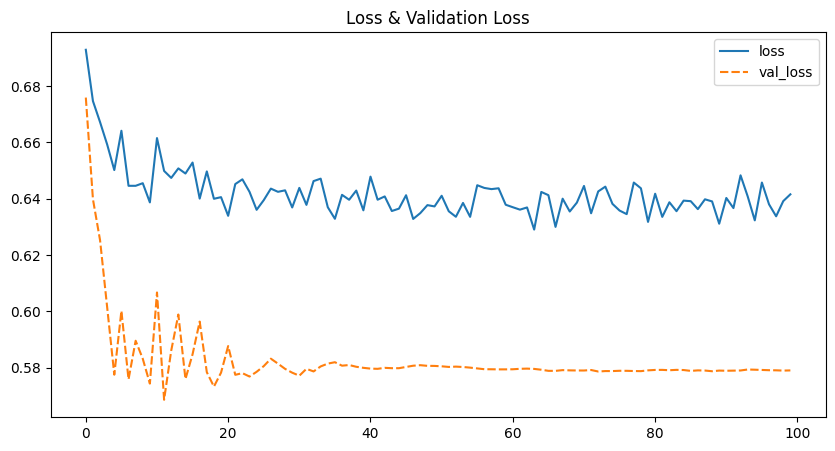

In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau


df = pd.read_csv("/content/weather_data_preprocessed.csv")

df["date"] = pd.to_datetime(df["date"])
df["day_of_year"] = df["date"].dt.dayofyear
df["month"] = df["date"].dt.month
df["season"] = df["month"] % 12 // 3 + 1

features = ["pressure", "avg_temperature", "avg_wind_speed", "cloud_cover", "day_of_year", "season"]
X = df[features]
y = df["rain_or_not"]

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

def create_sequences(data, labels, sequence_length=10):
    Xs, ys = [], []
    for i in range(len(data) - sequence_length):
        Xs.append(data[i : i + sequence_length])
        ys.append(labels[i + sequence_length])
    return np.array(Xs), np.array(ys)

sequence_length = 10
X_seq, y_seq = create_sequences(X_scaled, y.values, sequence_length)

X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42, stratify=y_seq)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42, stratify=y_train)

class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y_train), y=y_train)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(sequence_length, X_train.shape[2])),
    Dropout(0.3),

    LSTM(64, return_sequences=True),
    Dropout(0.3),

    LSTM(32),
    Dropout(0.3),

    Dense(1, activation="sigmoid")  # Binary classification
])

model.compile(optimizer=Adam(learning_rate=0.001), loss="binary_crossentropy", metrics=["accuracy"])

lr_scheduler = ReduceLROnPlateau(monitor="val_loss", patience=5, factor=0.5, min_lr=1e-5)

history = model.fit(X_train, y_train, validation_data=(X_val, y_val),
                    epochs=100, batch_size=32, verbose=1, class_weight=class_weight_dict,
                    callbacks=[lr_scheduler])

his = pd.DataFrame(history.history)

plt.figure(figsize=(10,5))
sns.lineplot(data=his[["loss", "val_loss"]])
plt.title("Loss & Validation Loss")
plt.show()


Test Loss: 0.6597
Test Accuracy: 0.6066
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 504ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.48      0.57      0.52        23
           1       0.71      0.63      0.67        38

    accuracy                           0.61        61
   macro avg       0.59      0.60      0.59        61
weighted avg       0.62      0.61      0.61        61



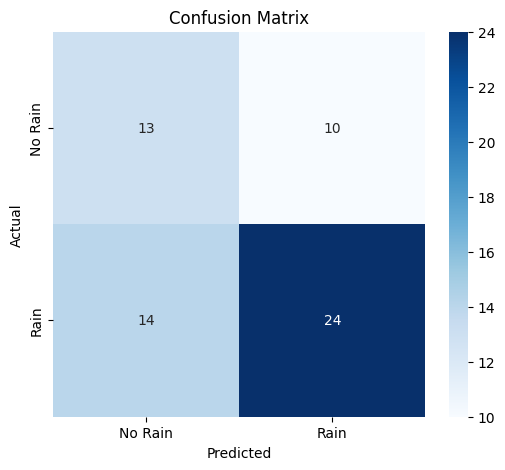

In [39]:
from sklearn.metrics import classification_report, confusion_matrix

test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)  # Convert probabilities to binary labels

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No Rain", "Rain"], yticklabels=["No Rain", "Rain"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


# Hyperparameter Optimization

In [40]:
import pandas as pd
import numpy as np
import warnings
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
import lightgbm as lgb
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from imblearn.combine import SMOTEENN


warnings.filterwarnings("ignore")

df = pd.read_csv('/content/weather_data_preprocessed.csv')

df = df.drop(columns=['date', 'humidity'])

X = df.drop(columns=['rain_or_not'])
y = df['rain_or_not']

# Standardization
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply SMOTE-ENN
smote_enn = SMOTEENN(random_state=42)
X_resampled, y_resampled = smote_enn.fit_resample(X_scaled, y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)

# Define base models
rf = RandomForestClassifier(random_state=42)
xgb_model = xgb.XGBClassifier(eval_metric='logloss', random_state=42)
dt = DecisionTreeClassifier(random_state=42)
lgbm_model = lgb.LGBMClassifier(random_state=42, verbosity=-1)

param_grid = {
    'RandomForest__n_estimators': [100, 200],
    'RandomForest__max_depth': [10, 20],
   # 'XGBoost__n_estimators': [100, 200],
   # 'XGBoost__learning_rate': [0.01, 0.1],
    'LightGBM__n_estimators': [100, 200],
    'LightGBM__learning_rate': [0.01, 0.1]
}

ensemble_model = VotingClassifier(
    estimators=[
        ('RandomForest', rf),
       # ('XGBoost', xgb_model),
        #('DecisionTree', dt),
        ('LightGBM', lgbm_model)
    ],
    voting='soft'
)

grid_search = GridSearchCV(ensemble_model, param_grid, cv=3, scoring='accuracy', n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# Best model from GridSearchCV
best_model = grid_search.best_estimator_

# Predictions
y_pred = best_model.predict(X_test)
y_prob = best_model.predict_proba(X_test)[:, 1]

# Evaluation Metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob)

# Print best parameters & evaluation results
print("Best Parameters:", grid_search.best_params_)
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'ROC-AUC Score: {roc_auc:.4f}')


Fitting 3 folds for each of 16 candidates, totalling 48 fits
Best Parameters: {'LightGBM__learning_rate': 0.01, 'LightGBM__n_estimators': 200, 'RandomForest__max_depth': 10, 'RandomForest__n_estimators': 100}
Accuracy: 0.8846
Precision: 0.9091
Recall: 0.8333
F1 Score: 0.8696
ROC-AUC Score: 0.9345


In [41]:
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
import lightgbm as lgb
from sklearn.model_selection import cross_val_predict

# Define base models
rf = RandomForestClassifier(n_estimators=100, random_state=42)
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
dt = DecisionTreeClassifier(random_state=42)
lgbm_model = lgb.LGBMClassifier(n_estimators=100, learning_rate=0.1, random_state=42, verbosity=-1)

ensemble_model = VotingClassifier(
    estimators=[
        ('RandomForest', rf),
        #('XGBoost', xgb_model),
        #('DecisionTree', dt),
        ('LightBGM', lgbm_model)
    ],
    voting='soft'
)

# Fit the ensemble model
ensemble_model.fit(X_resampled, y_resampled)

probabilities = ensemble_model.predict_proba(X_resampled)

print("Evaluating Ensemble Model")
evaluate_model_with_cv(ensemble_model, X_resampled, y_resampled)

print("Probabilities for the first sample:", probabilities[0])

Evaluating Ensemble Model
Model: VotingClassifier
Cross-Validation Accuracy: 0.8575 (+/- 0.0731)
Cross-Validation ROC AUC: 0.9379 (+/- 0.0420)
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        66
           1       1.00      1.00      1.00        60

    accuracy                           1.00       126
   macro avg       1.00      1.00      1.00       126
weighted avg       1.00      1.00      1.00       126

--------------------------------------------------
Probabilities for the first sample: [0.70865536 0.29134464]
